In [1]:
import os
import sys
import random
import warnings
import glob
import datetime

import numpy as np
import pandas as pd
import pickle
import shutil
import socket
import json

import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from tqdm import tqdm
from itertools import chain
from scipy.ndimage.measurements import label
from PIL import ImageFile
import scipy.misc
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, f1_score
import imageio
import cv2
from pathlib import Path

from tensorflow import ones_like, equal
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf

import sys
sys.path.append('..')

In [2]:
noteBookName = "u_net_lv_seg.ipynb"

In [3]:
DATA_PATH = Path("/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic")

In [4]:
# Set some parameters
IMG_WIDTH = 112
IMG_HEIGHT = 112
IMG_CHANNELS = 1

number_foldes = 5 # 9
val_split = 0.1
batch_size = 48
epochs = 50
patience = 4  # for early stopping
min_delta = 0.0005

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 13
random.seed = seed
np.random.seed = seed
tf.random.seed = seed

In [5]:
# Get train and test IDs
input_files = next(os.walk(DATA_PATH / 'Videos'))[2]
input_files = [f for f in input_files if '.npz' in f]
target_files = sorted(next(os.walk(DATA_PATH / 'echo_tracings_filled'))[2])

In [6]:
number_data_samples = len(target_files)
X = np.zeros((number_data_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((number_data_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)  # maybe 'soft' GT
infos = []

to_delete = []
for i, file in tqdm((enumerate(target_files))):
    name_frame = file.split('_')
    name = name_frame[0]
    frame_nr = int(name_frame[-1].split('.')[0])
    
    input_file = DATA_PATH / 'Videos' / (name + '.npz')
    if os.path.exists(input_file):
        input_frame = np.load(input_file)['frames'][frame_nr]
        target = np.asarray(Image.open(DATA_PATH / 'echo_tracings_filled' / file))
        X[i, ..., 0] = input_frame
        Y[i, ..., 0] = target[..., 0]
        info = {'file': file, 'lv_size': np.sum(target >= 1), 'name': name, 'frame': frame_nr}
        infos.append(info)
    else:
        print(f"File {input_file} does not exist")
        to_delete.append(i)
        
for d_idx in to_delete:
    X = np.delete(X, d_idx, 0)
    Y = np.delete(Y, d_idx, 0)

10577it [28:28, 28.19it/s]

File /cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X4F8859C8AB4DA9CB.npz does not exist
File /cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X4F8859C8AB4DA9CB.npz does not exist


18427it [51:17, 17.07it/s]

File /cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X7F38FA8D4B7DA603.npz does not exist
File /cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X7F38FA8D4B7DA603.npz does not exist


19866it [55:18,  5.99it/s]


In [7]:
assert len(infos) == X.shape[0]

In [8]:
for i in range(0, len(infos)-1, 2):
    if infos[i]['lv_size'] > infos[i+1]['lv_size']:
        infos[i]['phase'] = 'dia'
        infos[i+1]['phase'] = 'sys'
    else:
        infos[i]['phase'] = 'sys'
        infos[i+1]['phase'] = 'dia'

In [9]:
def overlay_imgs(frame, prediction=None, groundtruth=None):
    
    if prediction is None:
        prediction = groundtruth
    
    if groundtruth is None:
        groundtruth = prediction
    
    overlayed = np.clip(np.dstack([0.75*frame + prediction,
                                     0.75*frame,
                                     0.75*frame + groundtruth]), a_min=0, a_max=1)
    
    return overlayed

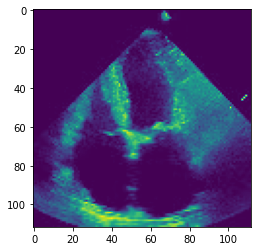

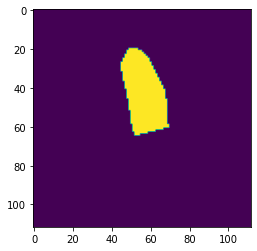

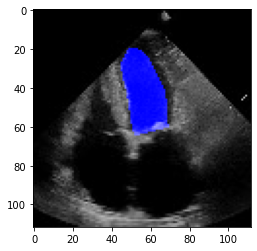

In [10]:
# Check if training data looks all right
ix = random.randint(0, number_data_samples-1)
plt.imshow(np.squeeze(X[ix]))
plt.show()
plt.imshow(np.squeeze(Y[ix]))
plt.show()
overlayed = overlay_imgs(np.squeeze(X[ix])/255.0, np.zeros(np.squeeze(Y[ix]).shape), np.squeeze(Y[ix]))
plt.imshow(overlayed)
plt.show()

In [11]:
def weighted_binary_crossentropy(w1, w2):
    '''
    w1 and w2 are the weights for the two classes.
    Computes weighted binary crossentropy
    Use like so:  model.compile(loss=weighted_binary_crossentropy(), optimizer="adam", metrics=["accuracy"])
    '''

    def loss(y_true, y_pred):
        # avoid absolute 0
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        ones = ones_like(y_true)
        msk = equal(y_true, ones)
        # tensor of booleans of length == y_true; true means that the true class is 1

        res, _ = tf.map_fn(lambda x: (mul(-tf.math.log(x[0]), w1) if x[1] is True
                                      else mul(-tf.math.log(1 - x[0]), w2), x[1]),
                           (y_pred, msk), dtype=(tf.float32, tf.bool))

        return res

    return loss

In [12]:
# Build U-Net model
def build_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255.0) (inputs)

    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
    c5 = BatchNormalization()(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])
    
    # model.compile(optimizer='adam', loss=weighted_binary_crossentropy(0.1, 0.9), metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])
    
    return model

In [13]:
def get_dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    
    denominator = im1.sum() + im2.sum()
    if denominator == 0:
        return 0

    return 2. * intersection.sum() / (denominator)

In [14]:
def get_iou(target, prediction):
    
    target = np.asarray(target).astype(np.bool)
    prediction = np.asarray(prediction).astype(np.bool)
    
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    
    denominator = np.sum(union)
    if denominator == 0:
        return 0
    
    iou_score = np.sum(intersection) / denominator
    return iou_score

In [15]:
# evaluate
def evaluate(inputs, targets, predictions, infos, experiment_path, split_idx):
    
    # save_path_train = os.path.join(experiment_path, 'evaluation/prediction/train')
    # save_path_test = os.path.join(experiment_path, 'evaluation/prediction/test')
 
    # os.makedirs(save_path_train, exist_ok=True)
    # os.makedirs(save_path_test, exist_ok=True)
    
    iou_values_dia = []
    iou_values_sys = []
    dice_values_dia = []
    dice_values_sys = []
    
    for i, pred in enumerate(predictions):
        
        pred = np.squeeze(pred)
        ground_truth = np.squeeze(targets[i])
        frame = np.squeeze(inputs[i])
        
        infos[i]['frame'] = frame
        infos[i]['prediction'] = pred
        infos[i]['target'] = ground_truth
        infos[i]['split'] = split_idx
        
        if infos[i]['phase'] == 'dia':
            iou_dia = get_iou(target=ground_truth, prediction=pred)
            infos[i]['iou_dia'] = iou_dia
            iou_values_dia.append(iou_dia)    
            
            dice_dia = get_dice(ground_truth, pred)
            infos[i]['dice_dia'] = dice_dia
            dice_values_dia.append(dice_dia)
        else:
            iou_sys = get_iou(target=ground_truth, prediction=pred)
            infos[i]['iou_sys'] = iou_sys
            iou_values_sys.append(iou_sys)    
            
            dice_sys = get_dice(ground_truth, pred)
            infos[i]['dice_sys'] = dice_sys
            dice_values_sys.append(dice_sys)
        
    return iou_values_dia, iou_values_sys, dice_values_dia, dice_values_sys

In [16]:
def print_scores(scores, n_foldes, name='iou_dia'):
    scores_foldes = []
    scores_splits = np.array_split(scores, number_foldes)
    for idx, split in enumerate(scores_splits):
        score_mean = np.mean(split)
        scores_foldes.append(score_mean)
        print(f"{name} fold {idx}: {score_mean}")

    print(f"\nAverage {name}: {np.mean(scores_foldes)}")
    print(f"Std {name}: {np.std(scores_foldes)}")
    print("\n\n")

### Run Model

In [17]:
run_name = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
run_name  += "_LV_segmentation_112x112"

print("Run: ", run_name)

experiment_path = os.path.join("experiments", run_name)
os.makedirs(experiment_path)

Xs = np.array_split(X, number_foldes)
Ys = np.array_split(Y, number_foldes)
infoss = np.array_split(infos, number_foldes)

model_results = []
ious_dia = []
ious_sys = []
dices_dia = []
dices_sys = []
for split_idx in range(number_foldes):
    
    print("\n\nTraining on fold Number: ", split_idx+1)
    
    X_train = []
    Y_train = []
    infos_train = []
    
    # select the training splits
    for idx in range(number_foldes):
        if idx != split_idx:
            X_train.extend(Xs[idx])
            Y_train.extend(Ys[idx])
            infos_train.extend(infoss[idx])
            
    X_train = np.asarray(X_train)[0:int(0.9*len(X_train)), ...]
    Y_train = np.asarray(Y_train)[0:int(0.9*len(Y_train)), ...]
    X_val = X_train[int(0.9*len(X_train)):, ...]
    Y_val = Y_train[int(0.9*len(Y_train)):, ...]

    
    # random shuffle within training
    perm = np.random.permutation(len(X_train))
    X_train = X_train[perm]
    Y_train = Y_train[perm]

    X_test = Xs[split_idx]
    Y_test = Ys[split_idx]
    
    infos_test = infoss[split_idx]
    
    # build and fit
    model = build_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    
    if split_idx == 0:
        print(model.summary())
    
    earlystopper = EarlyStopping(patience=patience, verbose=1, min_delta=min_delta, monitor='val_loss')
    checkpoint_file = os.path.join(experiment_path, "model_unet_checkpoint_split_{}.h5".format(split_idx))
    checkpointer = ModelCheckpoint(checkpoint_file, verbose=1, save_best_only=True, monitor='val_loss')
    
    result = model.fit(X_train, Y_train,
                       validation_data=(X_val, Y_val),
                       batch_size=batch_size,
                       epochs=epochs,
                       callbacks=[earlystopper, checkpointer])
    
    model_results.append(result)
    
    # make predictions using the best saved model (based on validation loss)
    model = load_model(checkpoint_file)
    # preds_train = model.predict(X_train[:int(X_train.shape[0]*val_split)])
    # preds_val = model.predict(X_train[int(X_train.shape[0]*val_split):])
    preds_test = model.predict(X_test)
    preds_test = preds_test > 0.5

    # evaluate (populates infos list of dictionaries)
    iou_dia, iou_sys, dice_dia, dice_sys = evaluate(X_test, Y_test, preds_test, infos_test, experiment_path, split_idx)
    ious_dia.extend(iou_dia)
    ious_sys.extend(iou_sys)
    dices_dia.extend(dice_dia)
    dices_sys.extend(dice_sys)
    
    # release memory and make sure we train new model from scratch in each fold
    print("Delete model and clear memory.")
    del model
    K.clear_session()

split_info = [{'file':i['file'], 'split':i['split']} for i in infos]
with open(os.path.join(experiment_path, 'split_info'), 'w') as fout:
    json.dump(split_info, fout)



Run:  2021-10-29_16-25-36_LV_segmentation_112x112


Training on fold Number:  1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 112, 112, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 320         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
______________

Epoch 1/50
298/298 [==============================] - 32s 89ms/step - loss: 0.1545 - accuracy: 0.9647 - mean_io_u: 0.6651 - val_loss: 0.1898 - val_accuracy: 0.9476 - val_mean_io_u: 0.7768

Epoch 00001: val_loss improved from inf to 0.18976, saving model to experiments/2021-10-29_16-25-36_LV_segmentation_112x112/model_unet_checkpoint_split_0.h5
Epoch 2/50
298/298 [==============================] - 24s 82ms/step - loss: 0.0466 - accuracy: 0.9837 - mean_io_u: 0.7241 - val_loss: 0.0428 - val_accuracy: 0.9831 - val_mean_io_u: 0.7144

Epoch 00002: val_loss improved from 0.18976 to 0.04281, saving model to experiments/2021-10-29_16-25-36_LV_segmentation_112x112/model_unet_checkpoint_split_0.h5
Epoch 3/50
298/298 [==============================] - 25s 83ms/step - loss: 0.0386 - accuracy: 0.9847 - mean_io_u: 0.7112 - val_loss: 0.0344 - val_accuracy: 0.9857 - val_mean_io_u: 0.7362

Epoch 00003: val_loss improved from 0.04281 to 0.03443, saving model to experiments/2021-10-29_16-25-36_LV_segmenta

298/298 [==============================] - 25s 83ms/step - loss: 0.0211 - accuracy: 0.9908 - mean_io_u: 0.7174 - val_loss: 0.0197 - val_accuracy: 0.9914 - val_mean_io_u: 0.7298

Epoch 00026: val_loss did not improve from 0.01970
Epoch 27/50
298/298 [==============================] - 25s 83ms/step - loss: 0.0213 - accuracy: 0.9907 - mean_io_u: 0.7124 - val_loss: 0.0187 - val_accuracy: 0.9918 - val_mean_io_u: 0.7305

Epoch 00027: val_loss improved from 0.01970 to 0.01874, saving model to experiments/2021-10-29_16-25-36_LV_segmentation_112x112/model_unet_checkpoint_split_0.h5
Epoch 28/50
298/298 [==============================] - 25s 83ms/step - loss: 0.0203 - accuracy: 0.9911 - mean_io_u: 0.7190 - val_loss: 0.0182 - val_accuracy: 0.9921 - val_mean_io_u: 0.7267

Epoch 00028: val_loss improved from 0.01874 to 0.01821, saving model to experiments/2021-10-29_16-25-36_LV_segmentation_112x112/model_unet_checkpoint_split_0.h5
Epoch 29/50
298/298 [==============================] - 25s 83ms/step 


Epoch 00001: val_loss improved from inf to 0.09594, saving model to experiments/2021-10-29_16-25-36_LV_segmentation_112x112/model_unet_checkpoint_split_1.h5
Epoch 2/50
298/298 [==============================] - 25s 83ms/step - loss: 0.0498 - accuracy: 0.9832 - mean_io_u: 0.7302 - val_loss: 0.0392 - val_accuracy: 0.9850 - val_mean_io_u: 0.7372

Epoch 00002: val_loss improved from 0.09594 to 0.03918, saving model to experiments/2021-10-29_16-25-36_LV_segmentation_112x112/model_unet_checkpoint_split_1.h5
Epoch 3/50
298/298 [==============================] - 25s 83ms/step - loss: 0.0391 - accuracy: 0.9847 - mean_io_u: 0.7188 - val_loss: 0.0347 - val_accuracy: 0.9858 - val_mean_io_u: 0.6955

Epoch 00003: val_loss improved from 0.03918 to 0.03469, saving model to experiments/2021-10-29_16-25-36_LV_segmentation_112x112/model_unet_checkpoint_split_1.h5
Epoch 4/50
298/298 [==============================] - 25s 83ms/step - loss: 0.0357 - accuracy: 0.9854 - mean_io_u: 0.7022 - val_loss: 0.0335 -


Epoch 00003: val_loss improved from 0.05454 to 0.03935, saving model to experiments/2021-10-29_16-25-36_LV_segmentation_112x112/model_unet_checkpoint_split_2.h5
Epoch 4/50
298/298 [==============================] - 25s 83ms/step - loss: 0.0345 - accuracy: 0.9856 - mean_io_u: 0.7138 - val_loss: 0.0355 - val_accuracy: 0.9859 - val_mean_io_u: 0.7724

Epoch 00004: val_loss improved from 0.03935 to 0.03554, saving model to experiments/2021-10-29_16-25-36_LV_segmentation_112x112/model_unet_checkpoint_split_2.h5
Epoch 5/50
298/298 [==============================] - 25s 83ms/step - loss: 0.0329 - accuracy: 0.9861 - mean_io_u: 0.7115 - val_loss: 0.0306 - val_accuracy: 0.9870 - val_mean_io_u: 0.7107

Epoch 00005: val_loss improved from 0.03554 to 0.03062, saving model to experiments/2021-10-29_16-25-36_LV_segmentation_112x112/model_unet_checkpoint_split_2.h5
Epoch 6/50
298/298 [==============================] - 25s 84ms/step - loss: 0.0322 - accuracy: 0.9863 - mean_io_u: 0.7030 - val_loss: 0.03

298/298 [==============================] - 25s 85ms/step - loss: 0.0196 - accuracy: 0.9914 - mean_io_u: 0.6930 - val_loss: 0.0184 - val_accuracy: 0.9919 - val_mean_io_u: 0.6993

Epoch 00030: val_loss did not improve from 0.01789
Epoch 31/50
298/298 [==============================] - 25s 85ms/step - loss: 0.0188 - accuracy: 0.9918 - mean_io_u: 0.6985 - val_loss: 0.0167 - val_accuracy: 0.9927 - val_mean_io_u: 0.7325

Epoch 00031: val_loss improved from 0.01789 to 0.01672, saving model to experiments/2021-10-29_16-25-36_LV_segmentation_112x112/model_unet_checkpoint_split_2.h5
Epoch 32/50
298/298 [==============================] - 25s 85ms/step - loss: 0.0194 - accuracy: 0.9915 - mean_io_u: 0.6890 - val_loss: 0.0186 - val_accuracy: 0.9920 - val_mean_io_u: 0.7312

Epoch 00032: val_loss did not improve from 0.01672
Epoch 33/50
298/298 [==============================] - 25s 85ms/step - loss: 0.0188 - accuracy: 0.9918 - mean_io_u: 0.6875 - val_loss: 0.0163 - val_accuracy: 0.9930 - val_mean_io_


Epoch 00007: val_loss did not improve from 0.03018
Epoch 8/50
298/298 [==============================] - 25s 85ms/step - loss: 0.0313 - accuracy: 0.9865 - mean_io_u: 0.6925 - val_loss: 0.0336 - val_accuracy: 0.9863 - val_mean_io_u: 0.7738

Epoch 00008: val_loss did not improve from 0.03018
Epoch 9/50
298/298 [==============================] - 25s 85ms/step - loss: 0.0305 - accuracy: 0.9868 - mean_io_u: 0.6955 - val_loss: 0.0307 - val_accuracy: 0.9868 - val_mean_io_u: 0.7434

Epoch 00009: val_loss did not improve from 0.03018
Epoch 10/50
298/298 [==============================] - 25s 85ms/step - loss: 0.0295 - accuracy: 0.9872 - mean_io_u: 0.7002 - val_loss: 0.0281 - val_accuracy: 0.9879 - val_mean_io_u: 0.7096

Epoch 00010: val_loss improved from 0.03018 to 0.02812, saving model to experiments/2021-10-29_16-25-36_LV_segmentation_112x112/model_unet_checkpoint_split_3.h5
Epoch 11/50
298/298 [==============================] - 25s 84ms/step - loss: 0.0290 - accuracy: 0.9874 - mean_io_u: 0

iou_dia fold 0: 0.8797361367546523
iou_dia fold 1: 0.882564098379084
iou_dia fold 2: 0.8804440639155003
iou_dia fold 3: 0.8794846276390386
iou_dia fold 4: 0.8789555916479946

Average iou_dia: 0.8802369036672539
Std iou_dia: 0.001258347949440513



iou_sys fold 0: 0.8417377323794312
iou_sys fold 1: 0.843735514751657
iou_sys fold 2: 0.8437415069688371
iou_sys fold 3: 0.8458223508242645
iou_sys fold 4: 0.8446099121858487

Average iou_sys: 0.8439294034220076
Std iou_sys: 0.0013358639075780197



dice_dia fold 0: 0.9333232497886909
dice_dia fold 1: 0.9308248323841835
dice_dia fold 2: 0.9358695996313413
dice_dia fold 3: 0.9351192828158932
dice_dia fold 4: 0.9365001971259898

Average dice_dia: 0.9343274323492198
Std dice_dia: 0.0020495269206688726



dice_sys fold 0: 0.9154841545089403
dice_sys fold 1: 0.9090967765986977
dice_sys fold 2: 0.912632164390509
dice_sys fold 3: 0.9147043732735586
dice_sys fold 4: 0.9170260895746519

Average dice_sys: 0.9137887116692716
Std dice_sys: 0.0027402713228

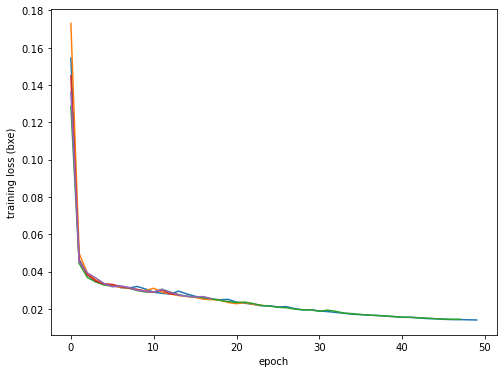

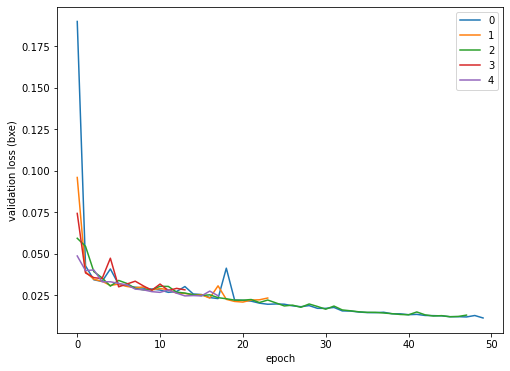

In [18]:
# print results
print_scores(ious_dia, n_foldes=number_foldes, name='iou_dia')
print_scores(ious_sys, n_foldes=number_foldes, name='iou_sys')
print_scores(dice_dia, n_foldes=number_foldes, name='dice_dia')
print_scores(dice_sys, n_foldes=number_foldes, name='dice_sys')


# training
fig = plt.figure(figsize=(8,6))
for i in range(number_foldes):
    if i in list(range(0,len(model_results))):
        plt.ylabel("training loss (bxe)")
        plt.xlabel("epoch")
        plt.plot(model_results[i].history['loss'])
        
fig = plt.figure(figsize=(8,6))
for i in range(number_foldes):
    if i in list(range(0,len(model_results))):
        plt.ylabel("validation loss (bxe)")
        plt.xlabel("epoch")
        plt.plot(np.clip(model_results[i].history['val_loss'], a_min=0, a_max=1), label=i)
plt.legend()
               
print("Finished: ", run_name)

In [19]:
len(list(filter(lambda i: i['split'] == 0, split_info)))

3973

In [20]:
low_to_high_sys = sorted([i for i in infos if 'iou_sys' in list(i.keys())], key=lambda x: x['iou_sys'], reverse=False)
low_to_high_dia = sorted([i for i in infos if 'iou_dia' in list(i.keys())], key=lambda x: x['iou_dia'], reverse=False)

0X10B04432B90E5AC2
0X10B04432B90E5AC2


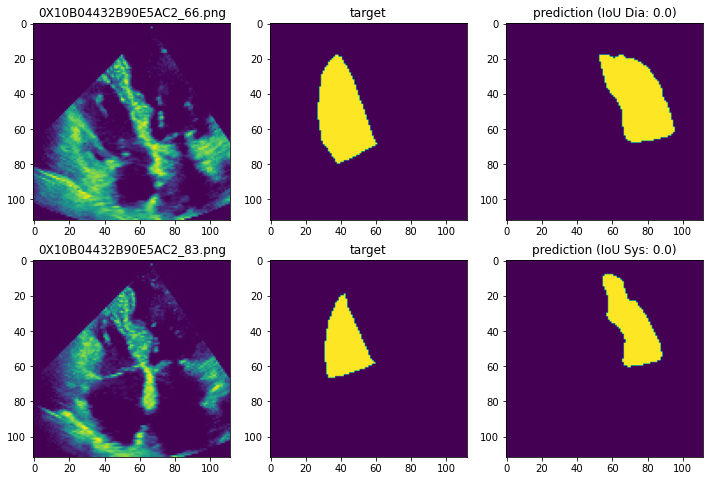

0X1BD7A625C9DA5292
0X1BD7A625C9DA5292


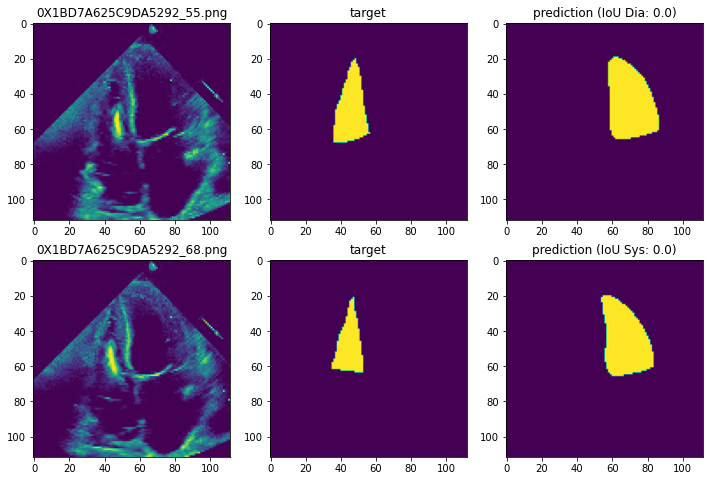

0X31C7FC69D6C348EA
0X22A9B6ECBD591065


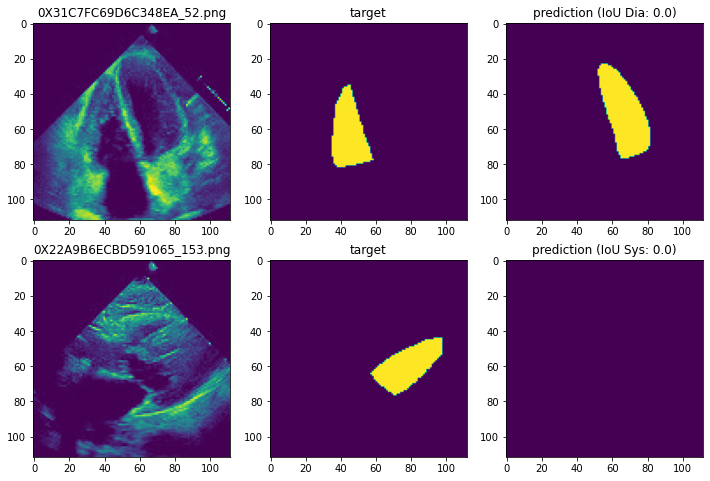

0X33EAE0F44B7618C1
0X31C7FC69D6C348EA


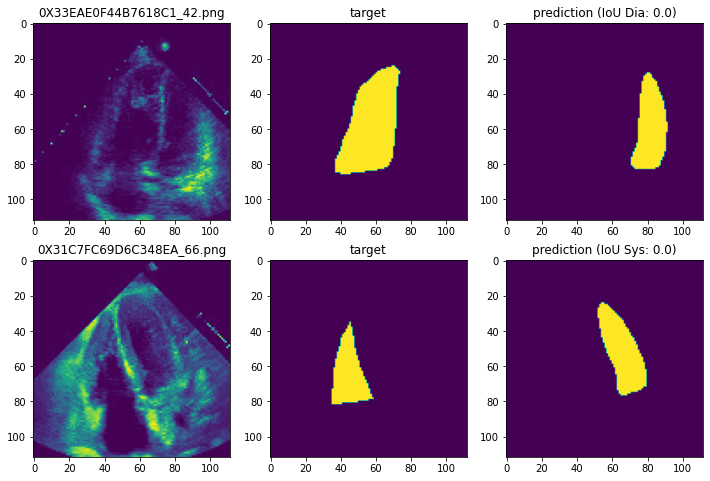

0X4F89846030713617
0X33EAE0F44B7618C1


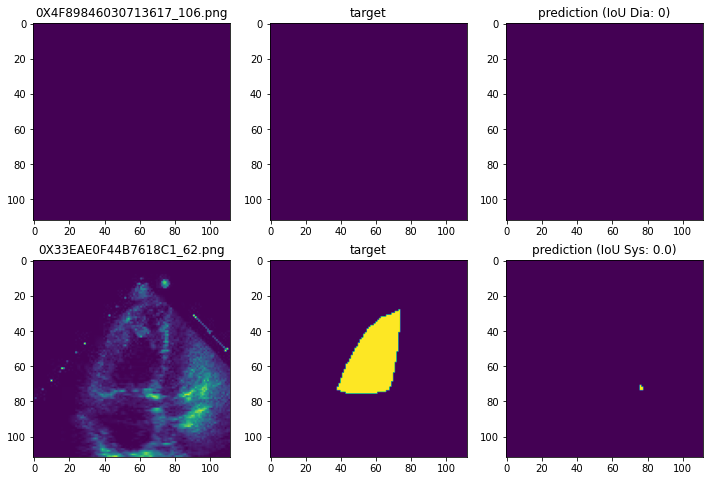

0X790C871B162806D2
0X52832AF3B2EE7826


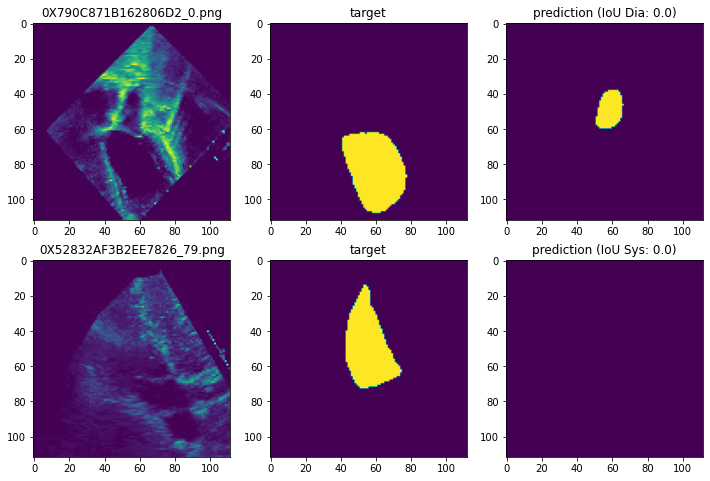

0X7F3ABE82B6992583
0X790C871B162806D2


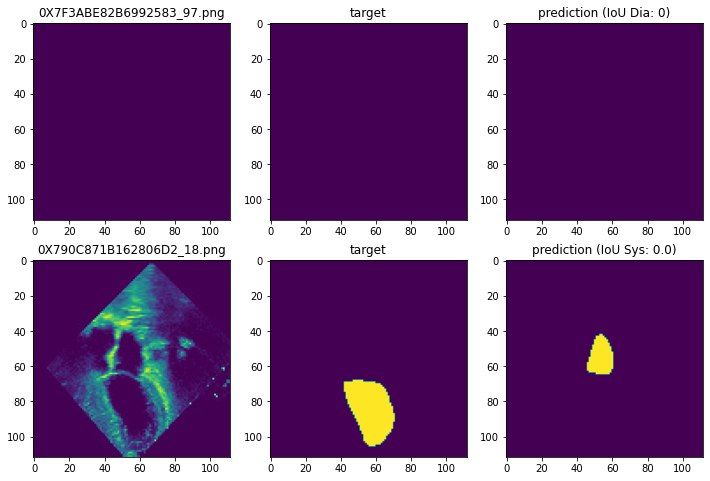

0X55DD5AB1762EDCDA
0X7F3ABE82B6992583


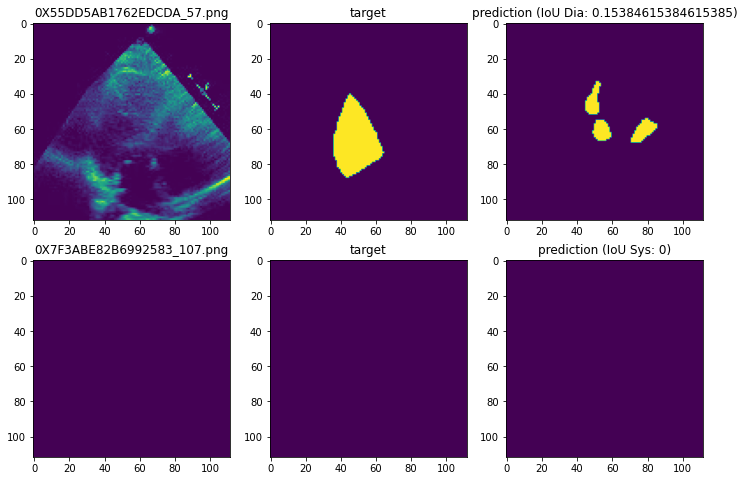

0X52832AF3B2EE7826
0X3FFFEF15F69088B5


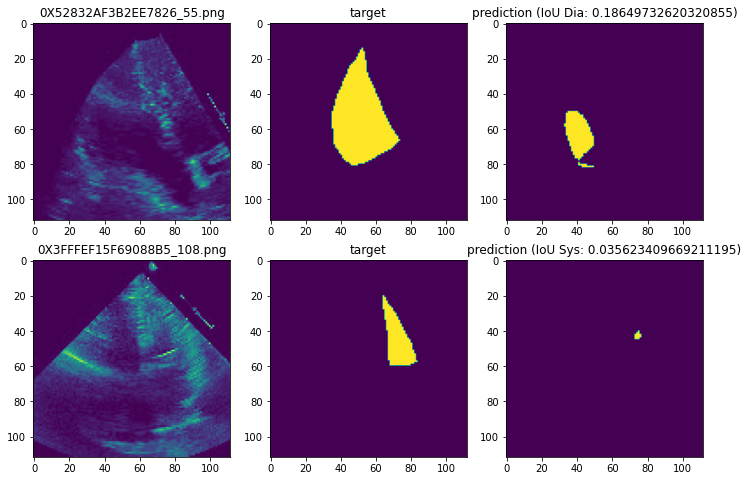

0X374099556945A9EA
0X286661146EB02EE4


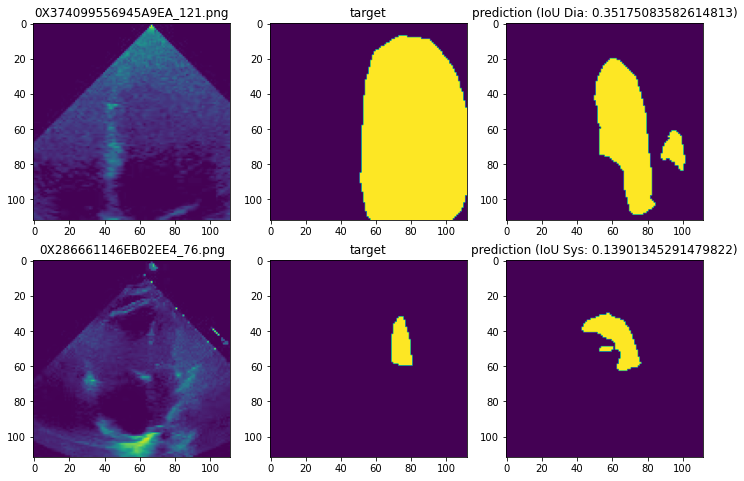

0X286661146EB02EE4
0X4A11C148E80CABDE


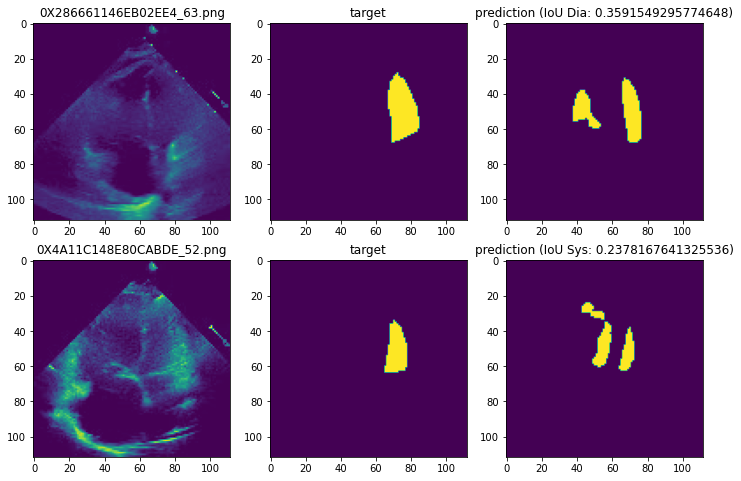

0X5DB7FAB9B9BE5D9
0X3BAE126085E973A0


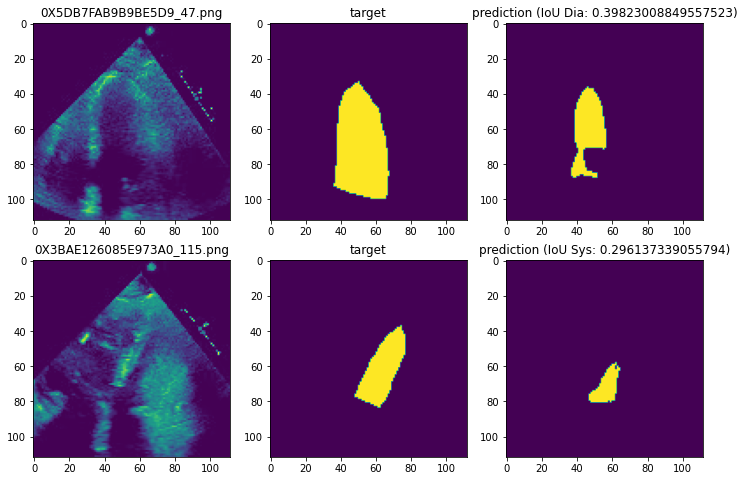

0XF599A765E273E17
0X7A61928840F41939


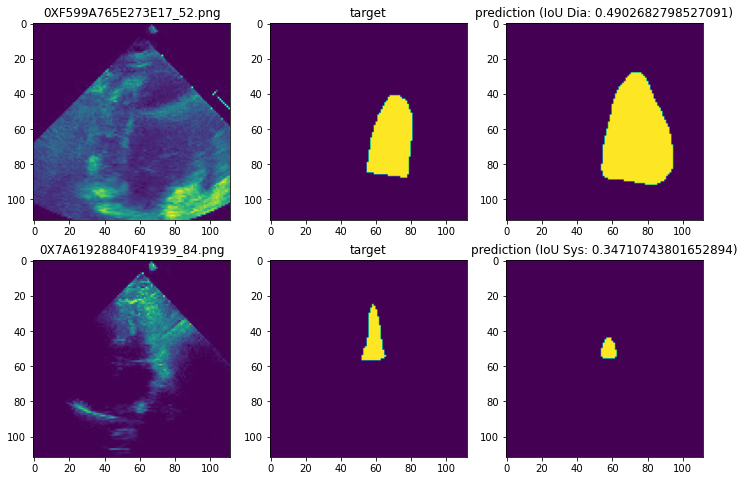

0X1E433E7966FD7332
0X64EE9FFA5DA69058


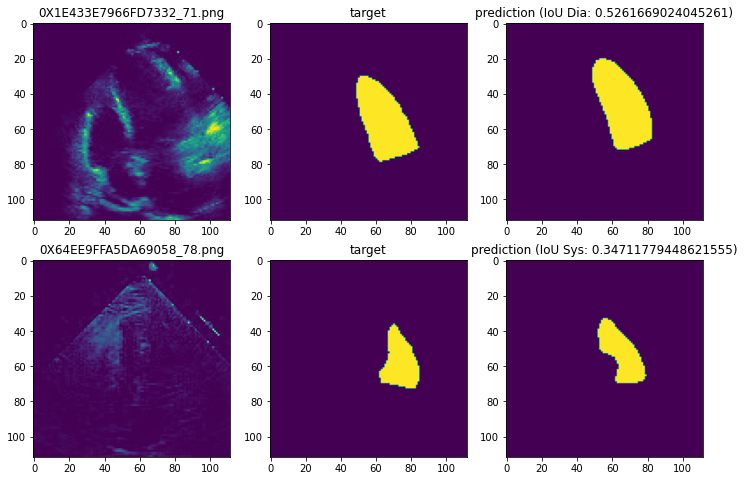

0X7CA9A912598CA322
0X50123D34D2500DE7


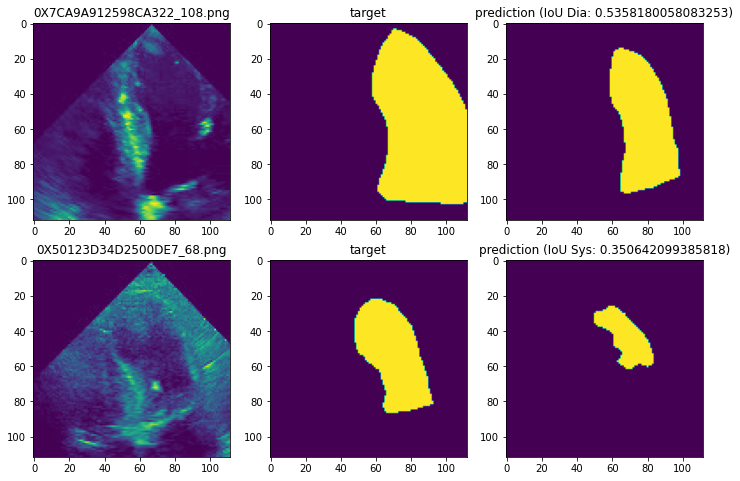

0X62473A8FCF726A75
0X49A2D5E5E1DAB5D0


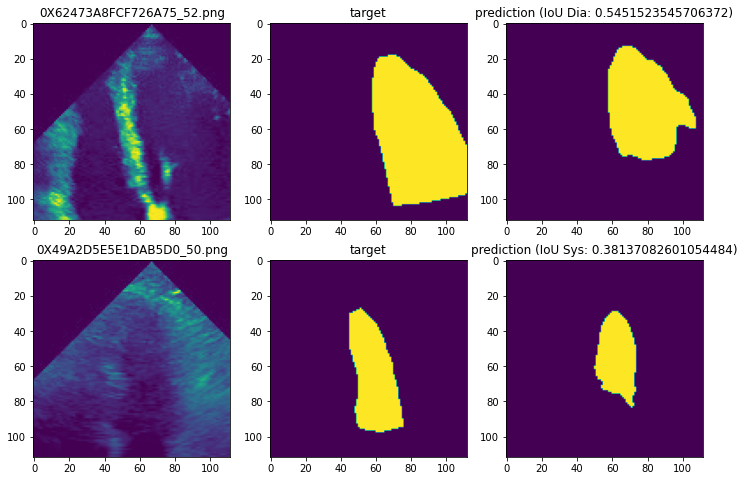

0X65F84656B24B5511
0X2A20552783F445AE


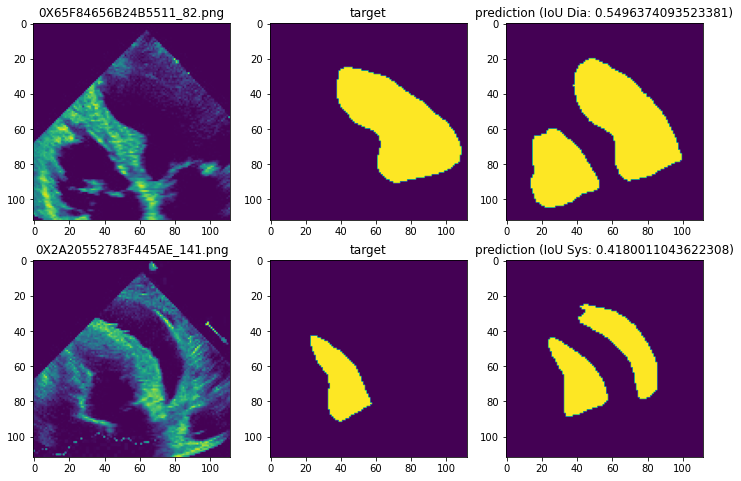

0X22E82C3D081C819C
0X710AB66715EBDE2E


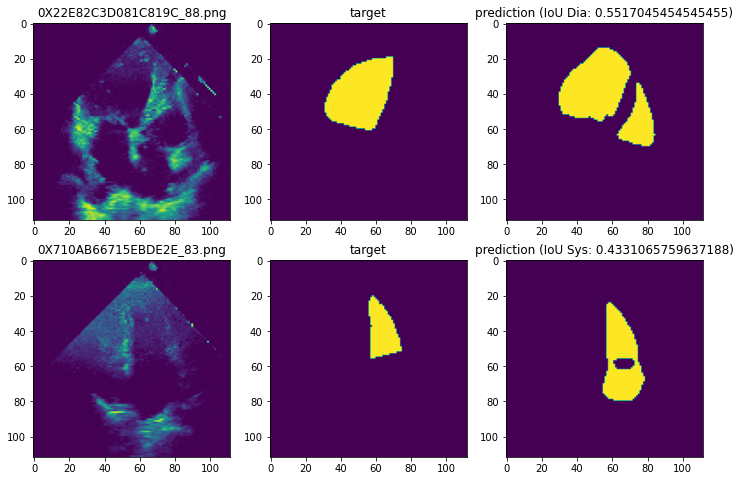

0X172CA389F7A02EEF
0X52619FC2739EB1F1


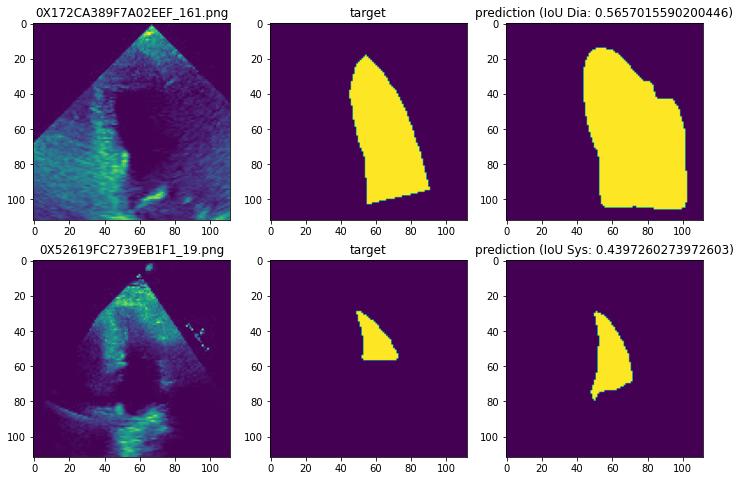

0X710EC36F325037EE
0X55DD5AB1762EDCDA


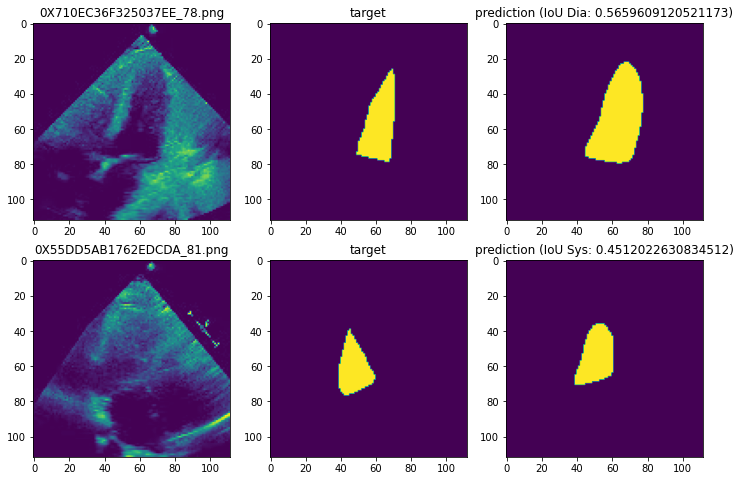

In [21]:
# worst predictions
bad_files = []
for i in range(0,20,1):
    print(low_to_high_dia[i]['name'])
    print(low_to_high_sys[i]['name'])
    bad_files.extend([low_to_high_dia[i]['name'], low_to_high_sys[i]['name']])
    
    fig, axs = plt.subplots(2,3, figsize=(12,8))
    axs[0,0].imshow(low_to_high_dia[i]['frame'])
    axs[0,0].set_title(low_to_high_dia[i]['file'])
    axs[0,1].imshow(low_to_high_dia[i]['target'])
    axs[0,1].set_title('target')
    axs[0,2].imshow(low_to_high_dia[i]['prediction'])
    axs[0,2].set_title(f"prediction (IoU Dia: {low_to_high_dia[i]['iou_dia']})")
    axs[1,0].imshow(low_to_high_sys[i]['frame'])
    axs[1,0].set_title(low_to_high_sys[i]['file'])
    axs[1,1].imshow(low_to_high_sys[i]['target'])
    axs[1,1].set_title('target')
    axs[1,2].imshow(low_to_high_sys[i]['prediction'])
    axs[1,2].set_title(f"prediction (IoU Sys: {low_to_high_sys[i]['iou_sys']})")
    plt.show()

0X5BA13657704CDD76
0X5537710165616E3F


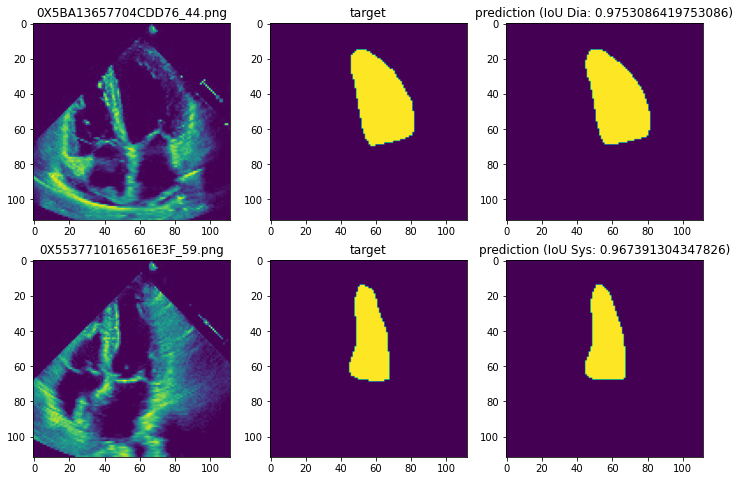

0X34A2487BD238406D
0X776060BC74A34C5F


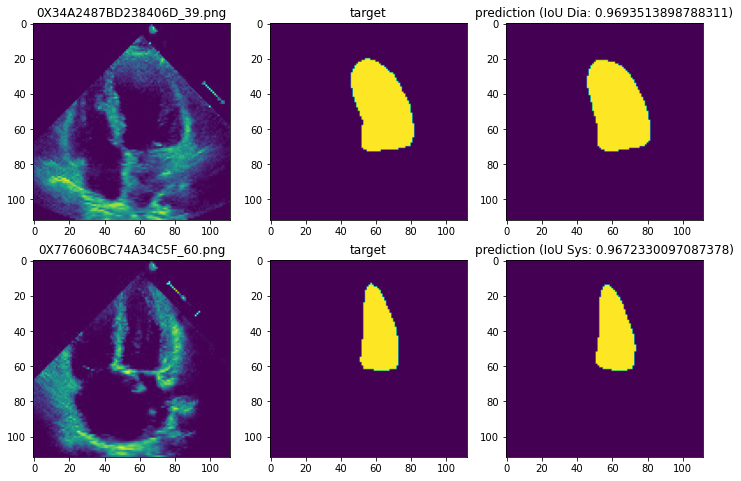

0X38B6140101279B52
0X330E6856301BBF9A


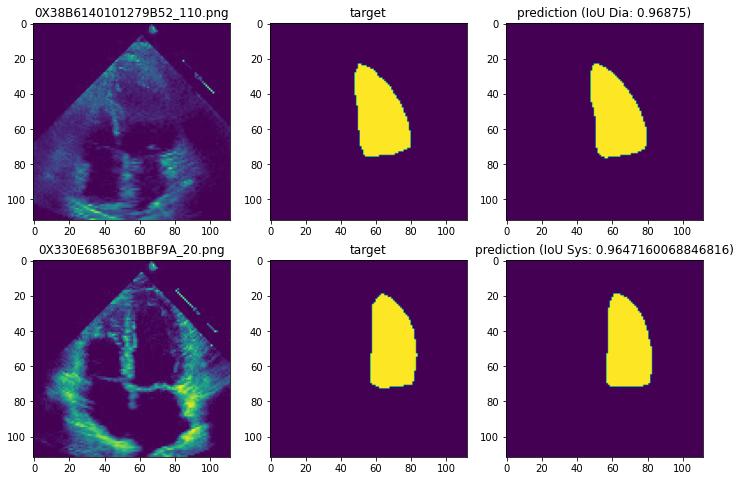

0X5BE6B8A080E4AAF3
0X574915FE8F47DA9D


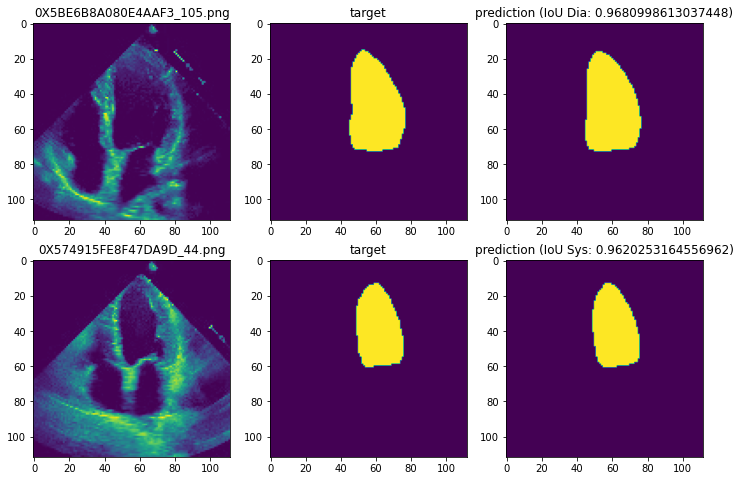

0X178269A4C18FC6B
0X4C237A567F5002FC


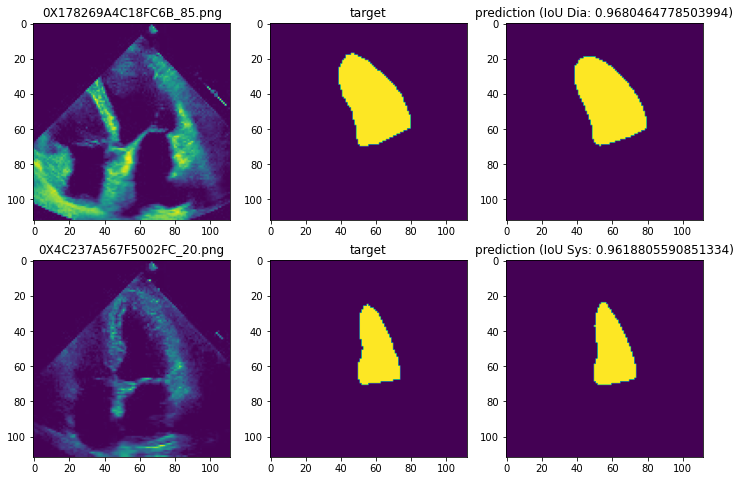

0X79116483627C83FB
0X74A87351D519ABBB


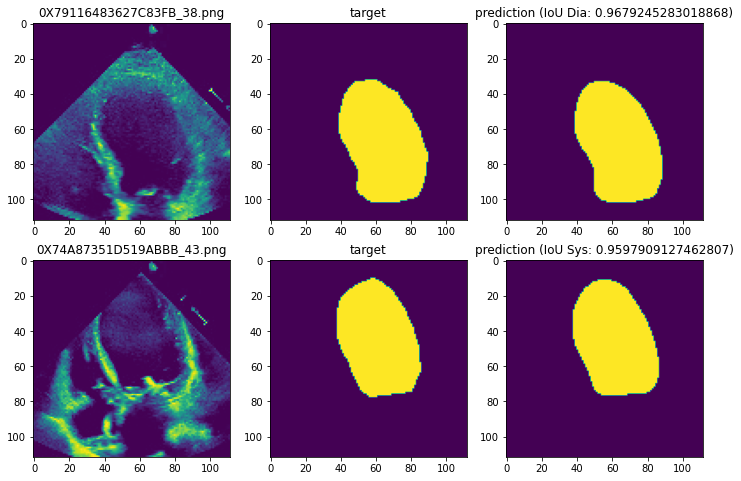

0X2B357569BC532F43
0X1F4145A50D7D74A1


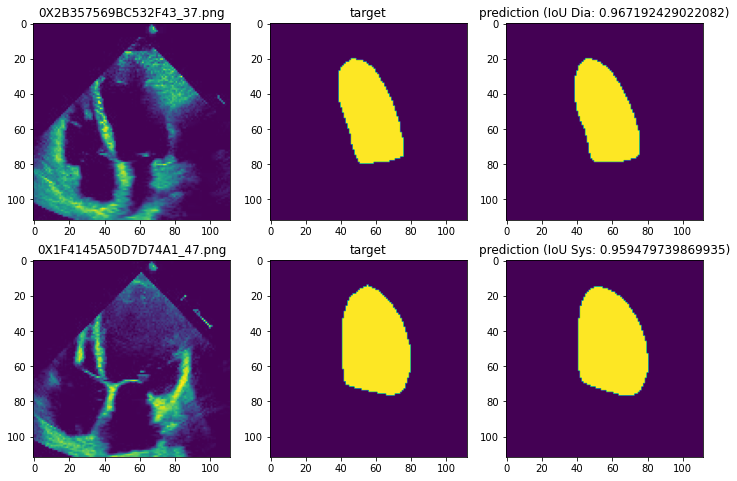

0X128C3C2C3A7496CB
0X8E2FCF5187C4872


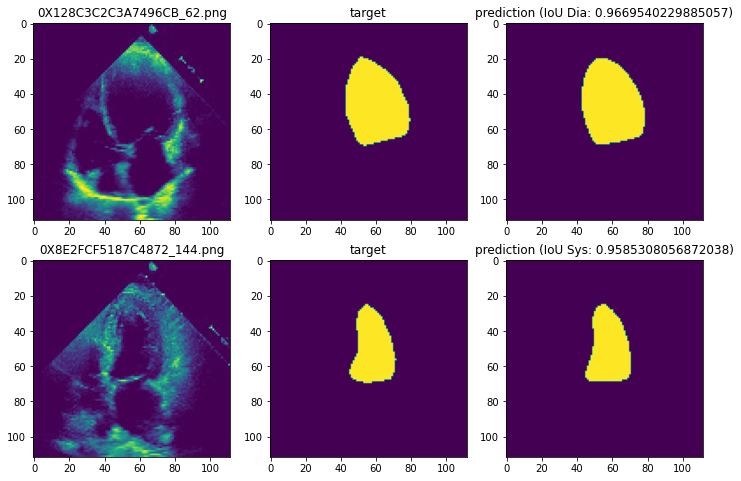

0X2840438B29E95F1F
0X59E816BD4AEDF902


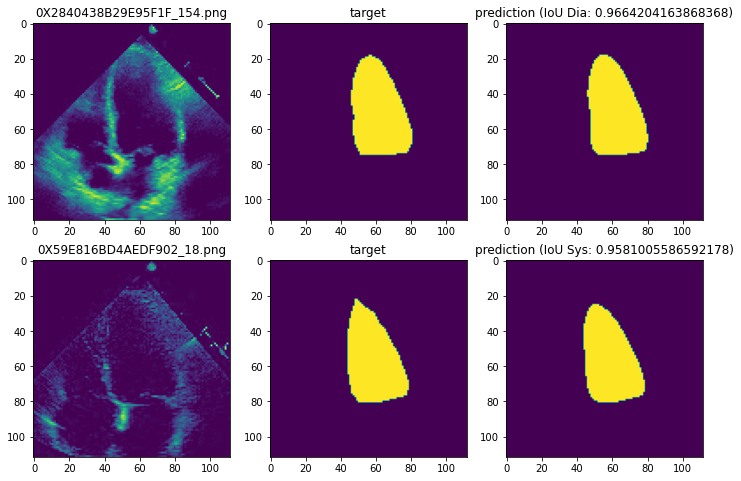

0X257EF0B5775B242F
0X6BDA434694AF0673


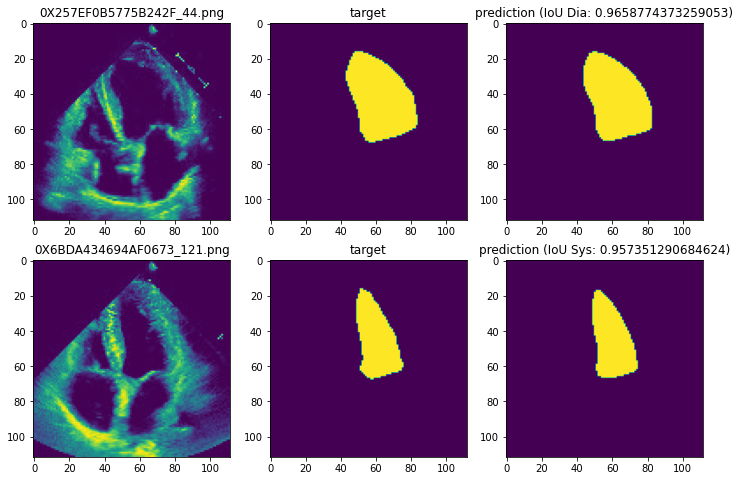

0X73F79A58680979D6
0X6BA126FDC669D53C


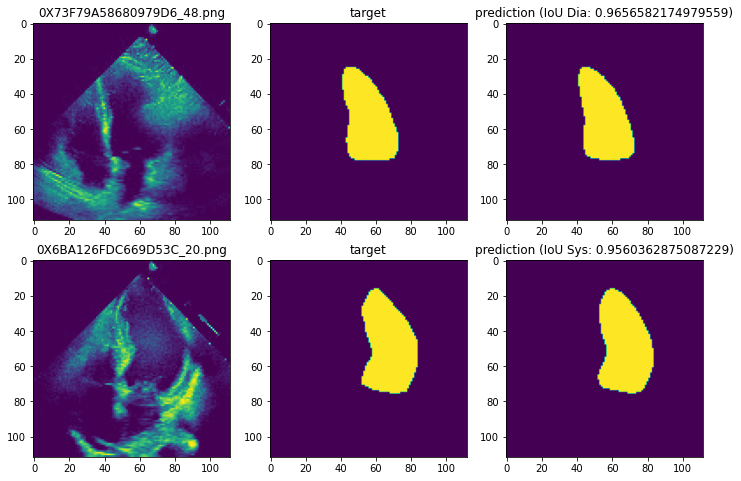

0X3E9510ADA06F09A9
0X3893725E893E66B1


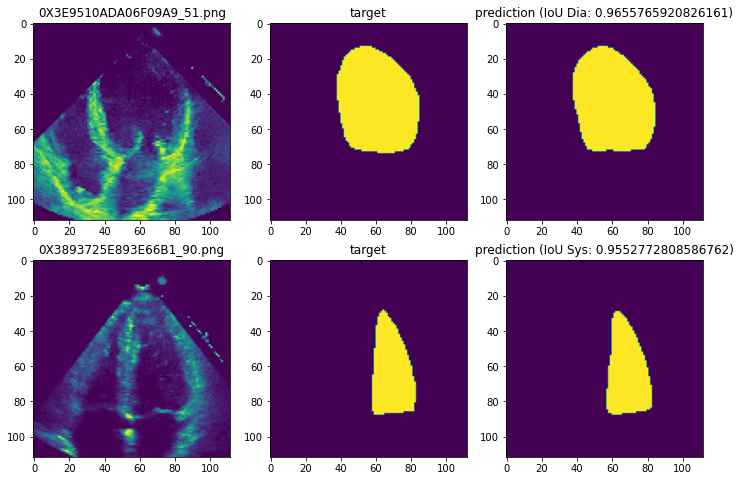

0X6918A5797070503
0X2F3ABF4B8389713F


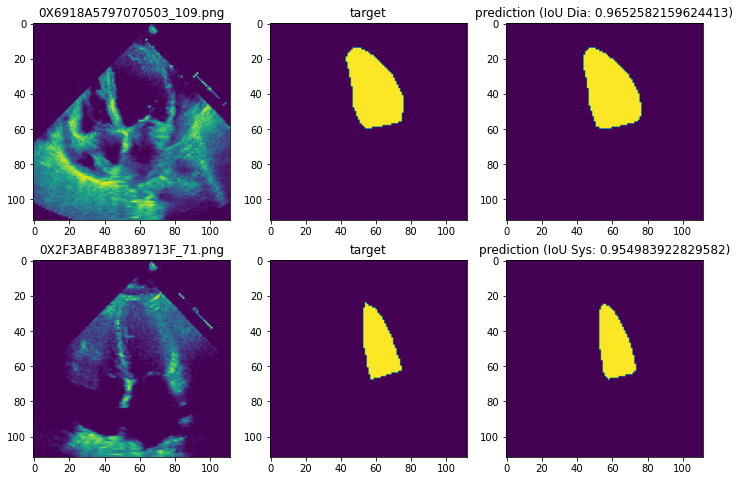

0XA69CDEAD15F2E1A
0X5232F0CB5A9F5EFE


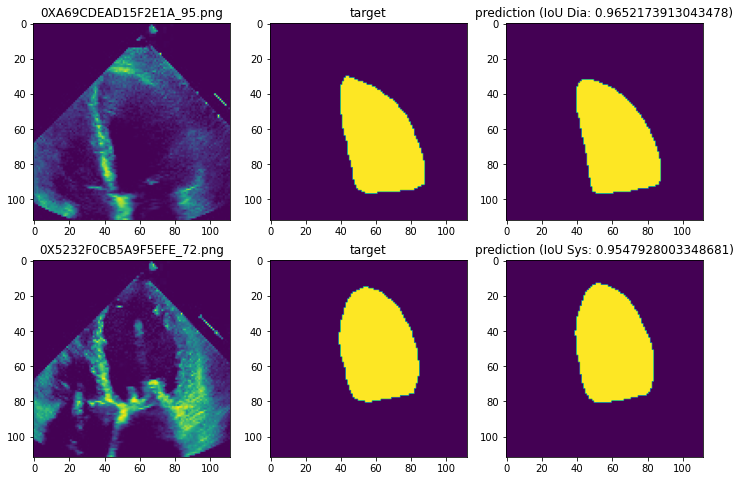

0X160DBDFED541D2D9
0X88CCC8BE9FDF7EA


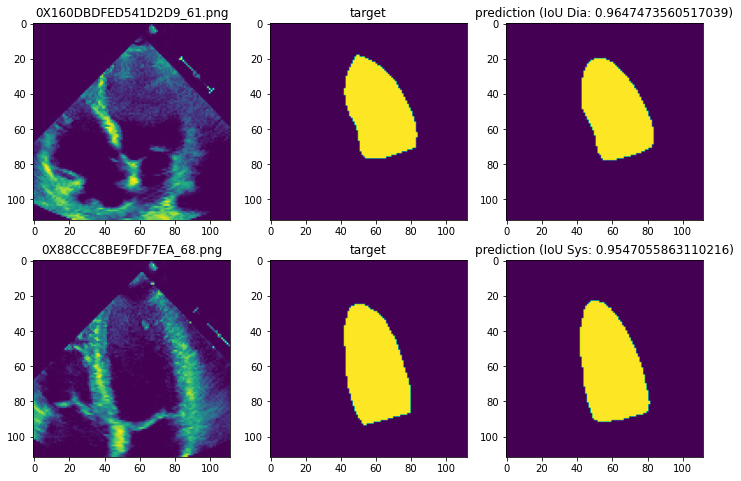

0X3E4992933C229E41
0X22D2668EC8BB8C20


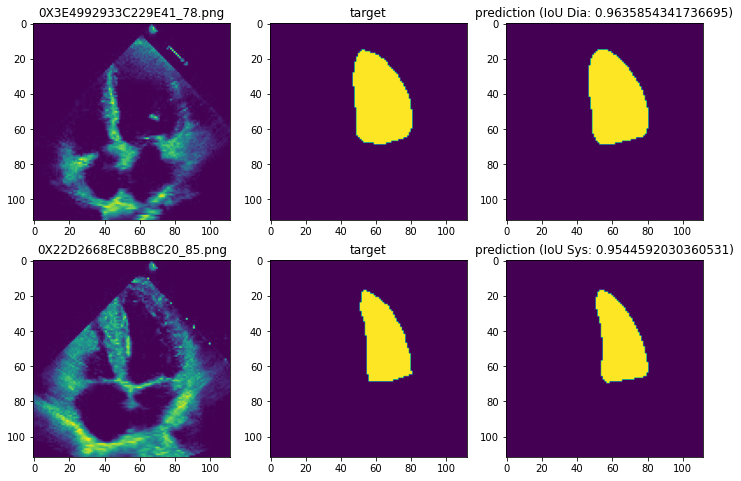

0X4CC16E6750678D36
0X3A7E305F4B67D1B5


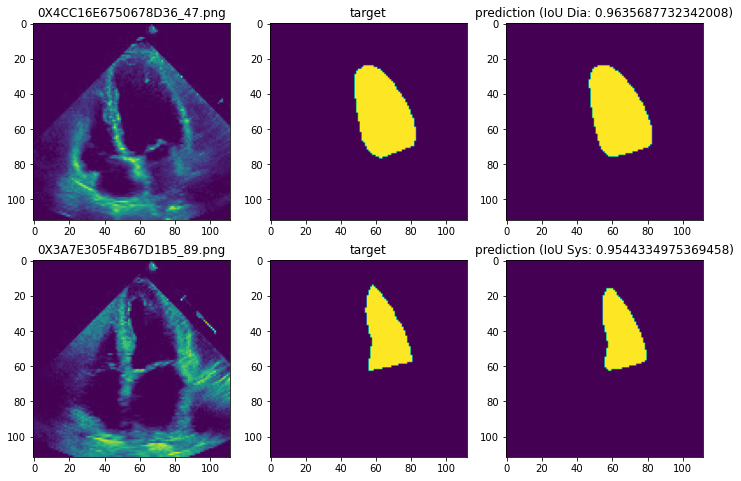

0X7313C9F94735726B
0X4BB8DC3E68BEB02F


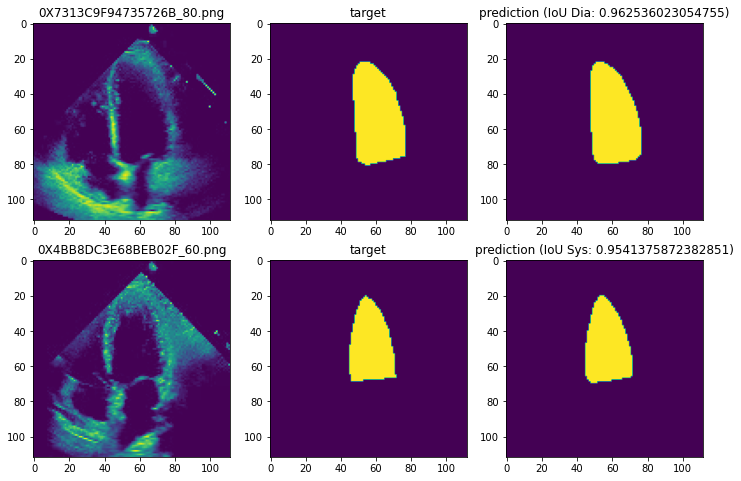

0X243FDE8AE0A05B6F
0X7FE620885816A032


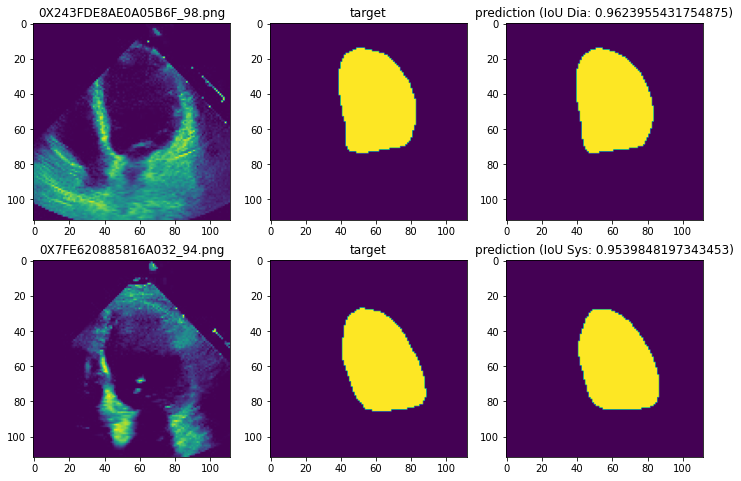

In [22]:
# best predictions
best_files = []
for i in range(-1,-20,-1):
    print(low_to_high_dia[i]['name'])
    print(low_to_high_sys[i]['name'])
    best_files.extend([low_to_high_dia[i]['name'], low_to_high_sys[i]['name']])
    
    fig, axs = plt.subplots(2,3, figsize=(12,8))
    axs[0,0].imshow(low_to_high_dia[i]['frame'])
    axs[0,0].set_title(low_to_high_dia[i]['file'])
    axs[0,1].imshow(low_to_high_dia[i]['target'])
    axs[0,1].set_title('target')
    axs[0,2].imshow(low_to_high_dia[i]['prediction'])
    axs[0,2].set_title(f"prediction (IoU Dia: {low_to_high_dia[i]['iou_dia']})")
    axs[1,0].imshow(low_to_high_sys[i]['frame'])
    axs[1,0].set_title(low_to_high_sys[i]['file'])
    axs[1,1].imshow(low_to_high_sys[i]['target'])
    axs[1,1].set_title('target')
    axs[1,2].imshow(low_to_high_sys[i]['prediction'])
    axs[1,2].set_title(f"prediction (IoU Sys: {low_to_high_sys[i]['iou_sys']})")
    plt.show()

/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X5BA13657704CDD76.npz 3 0.9753086419753086
/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X34A2487BD238406D.npz 1 0.9693513898788311
/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X38B6140101279B52.npz 1 0.96875
/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X5BE6B8A080E4AAF3.npz 3 0.9680998613037448
/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X178269A4C18FC6B.npz 0 0.9680464778503994


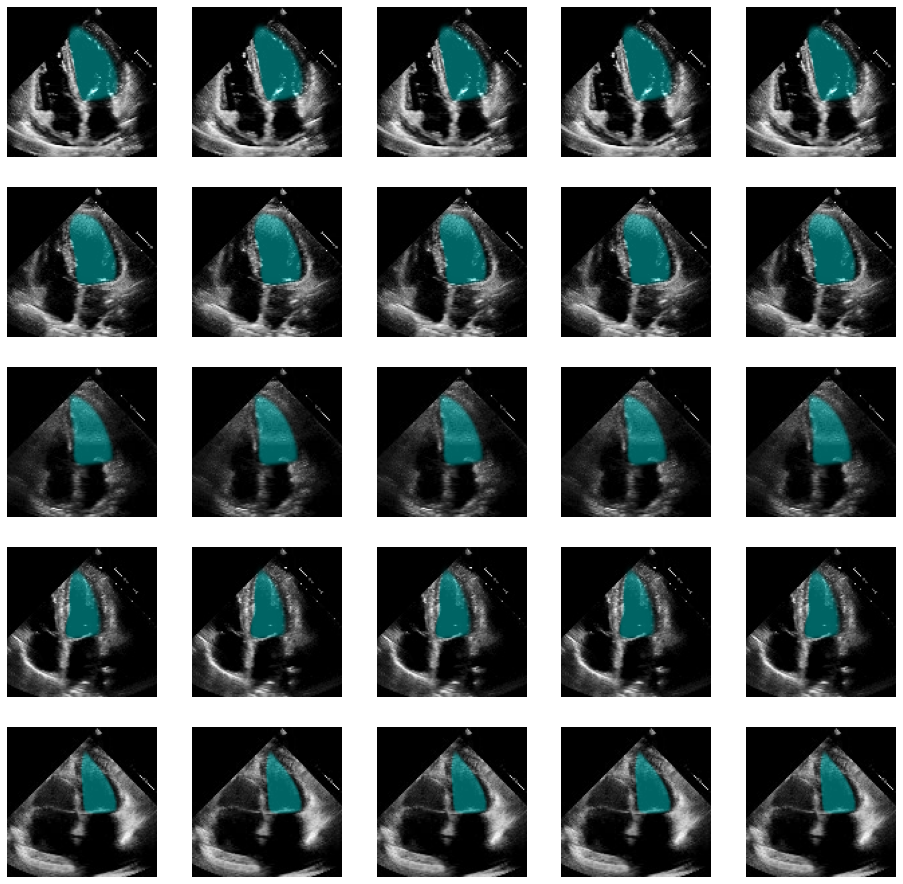

Delete model and clear memory.


In [23]:
# best predictions
fig, ax = plt.subplots(5, 5, figsize=(16,16))
brightness = 1.0

for i, f in enumerate(range(-1, -6, -1)):
    
    input_file = DATA_PATH / 'Videos' / (low_to_high_dia[f]['name'] + '.npz')
    input_frames = np.load(input_file)['frames']
    
    split = low_to_high_dia[f]['split']
    print(input_file, split, low_to_high_dia[f]['iou_dia'])
    
    checkpoint_file = os.path.join(experiment_path, "model_unet_checkpoint_split_{}.h5".format(split))
    model = load_model(checkpoint_file)
    pred_video = model.predict(input_frames)

    for j in range(5):
        frame = np.squeeze(input_frames[3*i, ...])
        prediction= np.squeeze(pred_video[3*i, ...])

        img_color = np.clip(np.dstack([frame*brightness, 
                                       (frame + 100*prediction)*brightness, 
                                       (frame + 100*prediction)*brightness]), a_min=0, a_max=255)
        img_color = img_color.astype(np.uint8)

        ax[i, j].imshow(img_color)
        ax[i,j].set_axis_off()
plt.savefig(os.path.join(experiment_path, 'best_predictions.pdf'))
plt.show()
print("Delete model and clear memory.")
del model
K.clear_session()

/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X67753ECB554BC154.npz 3 0.8912028725314183
/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X3972F3D228C6973.npz 1 0.8911819887429644
/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X8054AB409CF3EB.npz 4 0.8911806543385491
/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X7C6FB8F7CE82D404.npz 4 0.8911495422177009
/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X37C22AD689BE34F.npz 1 0.8911222780569514


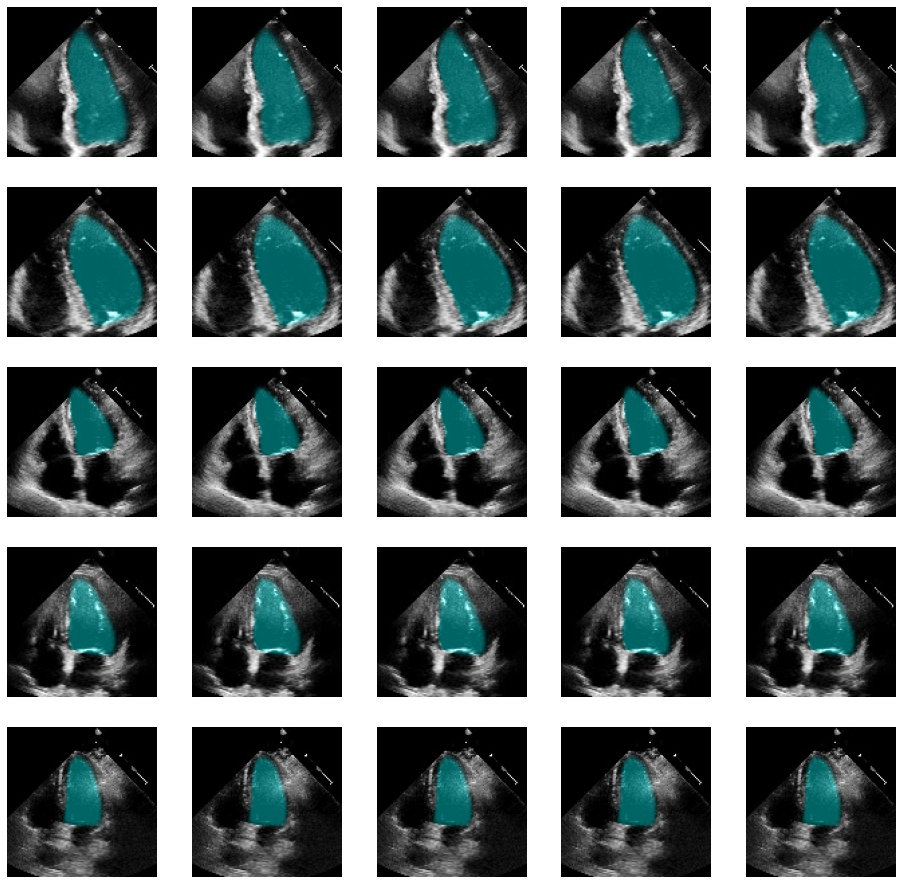

Delete model and clear memory.


In [24]:
# Median predictions
fig, ax = plt.subplots(5, 5, figsize=(16,16))
brightness = 1.0

for i, f in enumerate(range(int(len(low_to_high_dia)/2), int(len(low_to_high_dia)/2)-5, -1)):
    
    input_file = DATA_PATH / 'Videos' / (low_to_high_dia[f]['name'] + '.npz')
    input_frames = np.load(input_file)['frames']
    
    split = low_to_high_dia[f]['split']
    print(input_file, split, low_to_high_dia[f]['iou_dia'])
    
    checkpoint_file = os.path.join(experiment_path, "model_unet_checkpoint_split_{}.h5".format(split))
    model = load_model(checkpoint_file)
    pred_video = model.predict(input_frames)

    for j in range(5):
        frame = np.squeeze(input_frames[3*i, ...])
        prediction= np.squeeze(pred_video[3*i, ...])

        img_color = np.clip(np.dstack([frame*brightness, 
                                       (frame + 100*prediction)*brightness, 
                                       (frame + 100*prediction)*brightness]), a_min=0, a_max=255)
        img_color = img_color.astype(np.uint8)

        ax[i, j].imshow(img_color)
        ax[i,j].set_axis_off()
plt.savefig(os.path.join(experiment_path, 'median_predictions.pdf'))
plt.show()
print("Delete model and clear memory.")
del model
K.clear_session()

/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X55DD5AB1762EDCDA.npz 2 0.15384615384615385
/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X52832AF3B2EE7826.npz 2 0.18649732620320855
/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X374099556945A9EA.npz 1 0.35175083582614813
/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0X286661146EB02EE4.npz 0 0.3591549295774648
/cluster/dataset/shfn/laumerf/data/EchoNet-Dynamic/Videos/0XF599A765E273E17.npz 4 0.4902682798527091


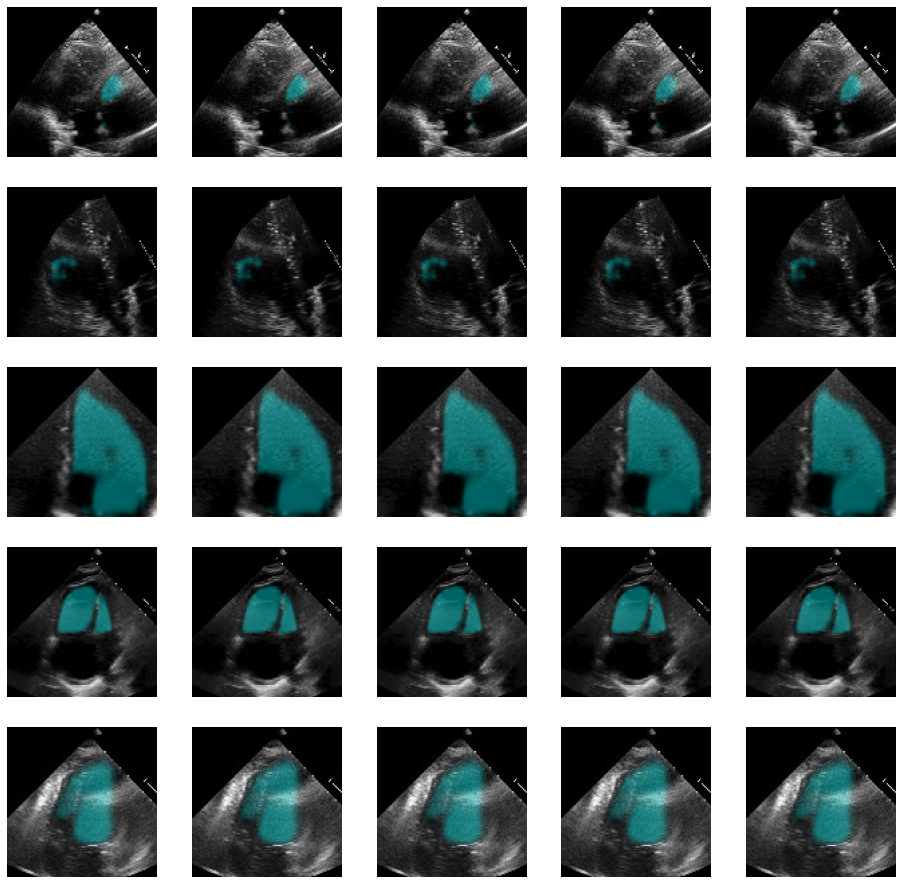

Delete model and clear memory.


In [30]:
# WORST Predictions
fig, ax = plt.subplots(5, 5, figsize=(16,16))
brightness = 1.0

# first 10 videos are wrongly labeled
for i, f in enumerate([7,8,9,10,12]):
    
    input_file = DATA_PATH / 'Videos' / (low_to_high_dia[f]['name'] + '.npz')
    input_frames = np.load(input_file)['frames']
    
    split = low_to_high_dia[f]['split']
    print(input_file, split, low_to_high_dia[f]['iou_dia'])
    
    checkpoint_file = os.path.join(experiment_path, "model_unet_checkpoint_split_{}.h5".format(split))
    model = load_model(checkpoint_file)
    pred_video = model.predict(input_frames)

    for j in range(5):
        frame = np.squeeze(input_frames[3*i, ...])
        prediction= np.squeeze(pred_video[3*i, ...])

        img_color = np.clip(np.dstack([frame*brightness, 
                                       (frame + 100*prediction)*brightness, 
                                       (frame + 100*prediction)*brightness]), a_min=0, a_max=255)
        img_color = img_color.astype(np.uint8)

        ax[i, j].imshow(img_color)
        ax[i,j].set_axis_off()
        
plt.savefig(os.path.join(experiment_path, 'worst_predictions.pdf'))
plt.show()
print("Delete model and clear memory.")
del model
K.clear_session()

## Legacy Code for MV segmentation

In [ ]:
score_path = os.path.join(experiment_path, 'scores') 
os.makedirs(score_path, exist_ok=True)
# save ious
print(ious)
f = open(os.path.join(score_path, "ious.pkl"),"wb")
pickle.dump(ious,f)
f.close()
print(dices)
f = open(os.path.join(score_path, "dices.pkl"),"wb")
pickle.dump(dices,f)
f.close()

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
# copy notebook
shutil.copy(noteBookName, experiment_path)

In [ ]:
# load another experiment
# experiment_path = os.path.join("experiments",  "2019-12-17_11-44-31_valve_segmentation_400x400")
# experiment_path = os.path.join("experiments",  "2019-12-17_10-32-16_valve_segmentation_400x400")

experiment_path = os.path.join("experiments",  "2019-12-16_18-58-41_valve_segmentation_400x400")

In [ ]:
## post-process & evaluate ##
morph_op = True
connected_struct = True
ious = []
dices = []
preds_video = []
data_info_splits = np.array_split(np.asarray(data_info), number_foldes)
for split_idx in range(number_foldes):
    
    data_info_test = data_info_splits[split_idx]
    echo_names = set([info['name'].split('4CH')[0] for info in data_info_test])
    
    model = build_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    checkpoint_file = os.path.join(experiment_path, "model_unet_checkpoint_split_{}.h5".format(split_idx))

    # load model
    print("Loading model: ", checkpoint_file)
    model = load_model(checkpoint_file)
    
    for echo_name in sorted(list(echo_names)): 
    
        print("Prediction for video: ", echo_name)
        

        infos = [info for info in data_info_test if info['name'].split('4CH')[0] in echo_name]
        assert len(infos) == number_lables_per_video

        pkl_file = infos[0]['name']
        # load original frame
        with open(os.path.join(str(PATH_PICKLE), pkl_file), 'rb') as f:
            dt = pickle.load(f)

        video = np.nan_to_num(dt.matrix3d)
        
        DATA = []
        for frame_idx in range(video.shape[-1]):
            frame = np.squeeze(video[..., frame_idx])
            assert np.max(frame) > 255/2  # check if uint8
            DATA.append({'frame': frame[..., np.newaxis]})

        # make prediction for the whole video
        preds_video = model.predict(np.asarray([data['frame'] for data in DATA]))
        
        kernel_erode = np.ones((5, 5), np.uint8)
        kernel_dilated = np.ones((5, 5), np.uint8)
        
        valve_video = np.zeros(video.shape)
        for frame_idx in range(preds_video.shape[0]):
            
            valve_pred = np.squeeze(preds_video[frame_idx, ...])
            
            valve_pred = (valve_pred > 0.5).astype(np.uint8)

            # valve_pred = (valve_pred > 0.5).astype(np.uint8)
            # valve_pred = (valve_pred > np.max(valve_pred) * 0.5).astype(np.uint8)
            # valve_pred = (valve_pred > 0).astype(np.uint8)  # => doesn't work! (everythin red)
            
            if morph_op:
                valve_pred = cv2.erode(valve_pred, kernel_erode, iterations=1)  # maybe iteration = 2
                valve_pred = cv2.dilate(valve_pred, kernel_dilated, iterations=1)

            valve_video[:, :, frame_idx] = valve_pred

        if connected_struct:
            structure = np.ones((3, 3, 3), dtype=np.int)

            # find connected commponents
            labeled, ncomp = label(valve_video, structure)
            components = sorted([(n, np.sum(labeled[labeled == n])) for n in range(1, ncomp + 1)],
                                key=lambda x: x[1],
                                reverse=True)

            print("Components video: ", components)
            
            if len(components) > 0:
                valve_video = np.zeros(labeled.shape)
                valve_video[labeled == components[0][0]] = 1

                # include other large components as well
                if len(components) > 1:
                    c_idx = 1
                    while components[c_idx][1] > 0.1 * components[0][1]:
                        print("Including next largest connected component.")
                        valve_video[labeled == components[c_idx][0]] = 1
                        c_idx += 1
                        
                        if len(components) == c_idx:
                            print("Trying to include non-existing component.")
                            break
        
        pred_frames = []
        info_frames = []
        for info in infos:
            info_frames.append(info)
            pred_frames.append(valve_video[..., info['frame']])
            
        iou, dice = evaluate(pred_frames, info_frames, experiment_path, split_idx, plot_predictions=True, save=False)
        ious.extend(iou)
        dices.extend(dice)
            
        pred_frames = []
        info_frames = []

    print("Deleting model and clearing session...")
    del model
    K.clear_session()
    
assert len(ious) == len(patients_pkl)*number_lables_per_video
    
# print results
iou_foldes = []
iou_scores_splits = np.array_split(ious, number_foldes)
for idx, split in enumerate(iou_scores_splits):
    iou_fold_mean = np.mean([iou['iou'] for iou in split])
    iou_foldes.append(iou_fold_mean)
    print("IOU fold {}: ".format(idx), iou_fold_mean)
    
print("Average IOU: ", np.mean(iou_foldes))
print("Std IOU: ", np.std(iou_foldes))

dice_foldes = []
dice_scores_splits = np.array_split(dices, number_foldes)
for idx, split in enumerate(dice_scores_splits):
    dice_fold_mean = np.mean([dice['dice'] for dice in split])
    dice_foldes.append(dice_fold_mean)
    print("DICE fold {}: ".format(idx), dice_fold_mean)
    
print("Average DICE: ", np.mean(dice_foldes))
print("Std DICE: ", np.std(dice_foldes))

print("Run: ", experiment_path)

In [ ]:
## create videos  ##

name = "LOERTSCHER"

data_info_splits = np.array_split(np.asarray(data_info), number_foldes)
for split_idx in range(number_foldes):
    
    
    data_info_test = data_info_splits[split_idx]
    echo_names = set([info['name'].split('4CH')[0] for info in data_info_test])
    
    model = build_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    checkpoint_file = os.path.join(experiment_path, "model_unet_checkpoint_split_{}.h5".format(split_idx))

    # load model
    print("Loading model: ", checkpoint_file)
    model = load_model(checkpoint_file)
    
    for echo_name in sorted(list(echo_names)): 
    
        print("Prediction for video: ", echo_name)
        infos = [info for info in data_info_test if info['name'].split('4CH')[0] in echo_name]
        
        if name not in echo_name:
            continue

        pkl_file = infos[0]['name']
        # load original frame
        with open(os.path.join(str(PATH_PICKLE), pkl_file), 'rb') as f:
            dt = pickle.load(f)

        video = np.nan_to_num(dt.matrix3d)
        
        DATA = []
        for frame_idx in range(video.shape[-1]):
            frame = np.squeeze(video[..., frame_idx])
            assert np.max(frame) > 255/2  # check if uint8
            DATA.append({'frame': frame[..., np.newaxis]})

        # make prediction for the whole video
        preds_video = model.predict(np.asarray([data['frame'] for data in DATA]))
        
        # save as npy
        save_path = os.path.join(experiment_path, 'videos')
        os.makedirs(save_path, exist_ok=True)
        file = os.path.join(save_path, echo_name[:-1] + ".npy")
        np.save(file = file, arr=preds_video)
            
    print("Deleting model and clearing session...")
    del model
    K.clear_session()

In [ ]:
## create AVI videos  ##
preds_test_upsampled = []
data_info_splits = np.array_split(np.asarray(data_info), number_foldes)
for split_idx in range(number_foldes):
    
    data_info_test = data_info_splits[split_idx]
    echo_names = set([info['name'].split('4CH')[0] for info in data_info_test])
    
    model = build_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    checkpoint_file = os.path.join(experiment_path, "model_unet_checkpoint_split_{}.h5".format(split_idx))

    # load model
    print("Loading model: ", checkpoint_file)
    model = load_model(checkpoint_file)
    
    for echo_name in sorted(list(echo_names)): 
    
        print("Prediction for video: ", echo_name)

        DATA = []
        for x, info in zip(X_all, data_info_all):

            if info['name'].split('4CH')[0] in echo_name:

                # load original frame
                x_original = imread(os.path.join(TEST_PATH, 'images', info['name']))

                assert x_original.shape[0] == info['original_size'][0]
                assert x_original.shape[1] == info['original_size'][1]

                DATA.append({'frame': x, 'x_original': x_original,  'original_size':info['original_size']})

        # make predictions
        preds_all = model.predict(np.asarray([data['frame'] for data in DATA]))

        # Create list of upsampled predictions
        print("Create images...")
        preds_test_upsampled = []
        for i in range(len(preds_all)):

            width = DATA[i]['original_size'][0]
            height = DATA[i]['original_size'][1]

            x_original = DATA[i]['x_original']

            image = X[i, ...]
            pred = preds_all[i]

            # Construct a colour image to superimpose
            color_mask = np.zeros((width, height, 3))

            # restore original size andthen do thresholding
            pred_test_rs = resize(np.squeeze(preds_all[i]), (width, height), mode='constant', preserve_range=True)

            # Threshold predictions (makes predicted segmentation smaller)
            pred_test_rs_t = (pred_test_rs >= np.max(pred_test_rs)*0.5).astype(np.uint8)

            # Construct RGB version of grey-level image
            frame = np.squeeze(x_original)
            img_color = np.clip(np.dstack([frame*0.75, frame*0.75, frame*0.75 + 100*pred_test_rs_t]), a_min=0, a_max=255)
            img_color = img_color.astype(np.uint8)

            preds_test_upsampled.append(img_color)
        
        # save as gif
        save_path = os.path.join(experiment_path, 'videos')
        os.makedirs(save_path, exist_ok=True)
        file = os.path.join(save_path, echo_name[:-1] + ".avi")
        imageio.mimsave(file, [np.asarray(frame, dtype=np.uint8) for frame in preds_test_upsampled],fps=25)
            
    print("Deleting model and clearing session...")
    del model
    K.clear_session()

In [ ]:
# load, predict, evaluate
ious = []
dices = []
for split_idx in range(number_foldes):
    
    print("Predictions for fold {}".format(split_idx+1))
    
    Xs = np.array_split(X, number_foldes)
    data_info_splits = np.array_split(np.asarray(data_info), number_foldes)

    X_test = Xs[split_idx]
    data_info_test = data_info_splits[split_idx]

    model = build_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    checkpoint_file = os.path.join(experiment_path, "model_unet_checkpoint_split_{}.h5".format(split_idx))

    # make predictions
    model = load_model(checkpoint_file)
    # preds_train = model.predict(X_train[:int(X_train.shape[0]*val_split)])
    # preds_val = model.predict(X_train[int(X_train.shape[0]*val_split):])
    preds_test = model.predict(X_test)

    # Create list of upsampled predictions
    preds_test_upsampled = []
    for i in range(len(preds_test)):
        width = data_info_test[i]['original_size'][0]
        height = data_info_test[i]['original_size'][1]
        
        # restore original size andthen do thresholding
        if resize_predictions:
            pred_test_rs = resize(np.squeeze(), (width, height), mode='constant', preserve_range=True)
        else:
            pred_test_rs = preds_test[i]
        
        # Threshold predictions (makes predicted segmentation smaller)
        pred_test_rs_t = (pred_test_rs >= np.max(pred_test_rs)*0.5).astype(np.uint8)
        
        preds_test_upsampled.append(pred_test_rs_t)

    # evaluate (iou)
    iou, dice = evaluate(preds_test_upsampled, data_info_test, experiment_path, split_idx)
    ious.extend(iou)
    dices.extend(dice)
    
    # release memory and make sure we train new model from scratch
    del model
    K.clear_session()
    
# print results
iou_foldes = []
iou_scores_splits = np.array_split(ious, number_foldes)
for idx, split in enumerate(iou_scores_splits):
    iou = np.mean([iou['iou'] for iou in split])
    iou_foldes.append(iou)
    print("IOU fold {}: ".format(idx), iou)
print("Average IOU: ", np.mean(iou_foldes))
print("Std IOU: ", np.std(iou_foldes))

print('\n')

dice_foldes = []
dice_scores_splits = np.array_split(dices, number_foldes)
for idx, split in enumerate(dice_scores_splits):
    dice = np.mean([dice['dice'] for dice in split])
    dice_foldes.append(dice)
    print("DICE fold {}: ".format(idx), dice)
print("Average DICE: ", np.mean(dice_foldes))
print("Std DICE: ", np.std(dice_foldes))